In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, ilr_inv, sbp_basis, inner
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn
from time import sleep

import seaborn as sns
sns.set_theme()

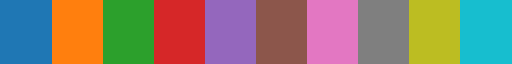

In [2]:
cm = plt.cm.tab10
colors = cm.colors
cm

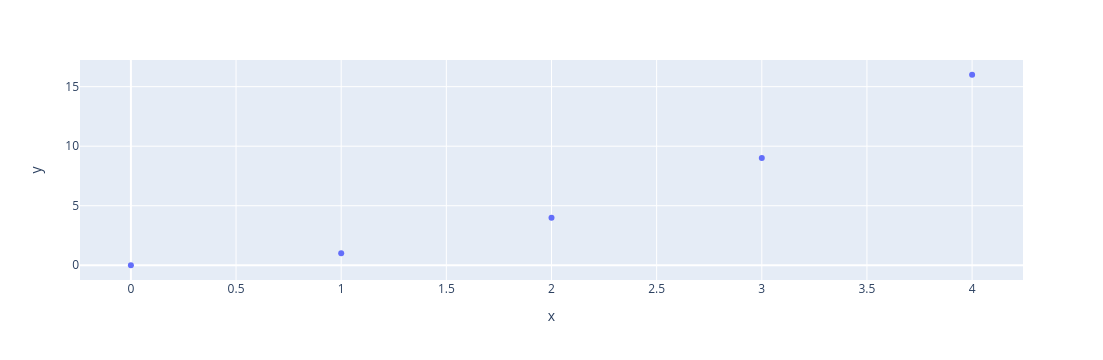

In [3]:
## Code to avoid having a "Loading [MathJax]/extensions/MathMenu.js" message
## in the following generated PDFS by plotly
import plotly.express as px

#garbage graph
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()
fig.write_image("random.pdf")

In [4]:
import os

out_dir = os.path.join('figures', '3classes')
os.makedirs(out_dir, exist_ok=True)

plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.format'] = 'pdf'

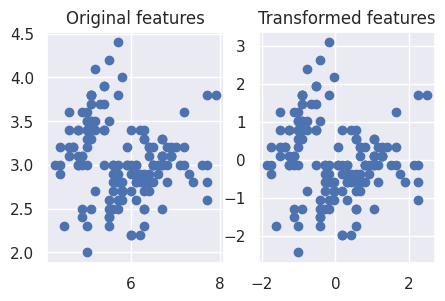

In [5]:
K = 13         #index of the instance you want to test in the test set
N_class = 3    #number of class, the dimension of the simplex is therefore N_class-1


#load the dataset and split into a training and testing set
data = datasets.load_iris()
(X, Y) = (data.data, data.target)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig, ax_list = plt.subplots(ncols=2, figsize=(5,3))
ax_list[0].set_title('Original features')
ax_list[0].scatter(X[:,0], X[:,1])
scaler.fit(X)
X = scaler.transform(X)
ax_list[1].set_title('Transformed features')
ax_list[1].scatter(X[:,0], X[:,1])
fig.savefig(os.path.join(out_dir, 'ex_eq3_standardized.pdf'))

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [6]:
#from sklearn.preprocessing import normalize
#fig = plt.figure()
#plt.scatter(X[:,0], X[:,1])
#X = normalize(X, axis=0)
#fig = plt.figure()
#plt.scatter(X[:,0], X[:,1])

In [7]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neural_network import MLPClassifier

#train an SVM classifier
clf = svm.SVC(kernel='rbf', probability=True)
#clf = MLPClassifier(hidden_layer_sizes=100, activation='logistic', solver='adam', max_iter=1000, tol=0.0001)

clf.fit(X_train, Y_train)

print(f"Training accuracy = {np.sum(clf.predict(X_train) == Y_train)} out of {Y_train.shape[0]}")
print(f"Test accuracy = {np.sum(clf.predict(X_test) == Y_test)} out of {Y_test.shape[0]}")

#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

# explain all the predictions in the test set
explainer = ShapleyExplainer(clf.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=data.target_names,
                            names_features=['sep. length','sep. width','pet. length','pet. width'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(data.target_names[Y_test[K]])

#get the model prediction for the Kth instance of the test partition
pred = clf.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)



Training accuracy = 115 out of 120
Test accuracy = 30 out of 30
True label of the tested instance: versicolor
Prediction on the simplex: [[0.0117559  0.80475589 0.18348821]]
Prediction in the ILR space: [-2.98836322 -0.51823312]
Sum of the shapley composition and the base distribution in the ILR space: [-2.98836322 -0.51823312]


In [8]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 pet. width: 1.2123156
	 pet. length: 1.019914
	 sep. width: 0.3217343
	 sep. length: 0.2679196

Projection of the Shapley compositions on the class vectors:
		sep. length	sep. width	pet. length	pet. width	
setosa:   	-0.2616337	-0.3015334	-0.9088694	-0.9895968	
versicolor:	0.1807822	0.0535921	0.8552286	1.1012681	
virginica:	0.0808515	0.2479414	0.0536408	-0.1116713	

Cosine between each Shapley compositions:
		sep. length	sep. width	pet. length	pet. width	
sep. length:	1.0000000	0.8401204	0.9679311	0.9215281	
sep. width:	0.8401204	1.0000000	0.6769192	0.5635744	
pet. length:	0.9679311	0.6769192	1.0000000	0.9895258	
pet. width:	0.9215281	0.5635744	0.9895258	1.0000000	


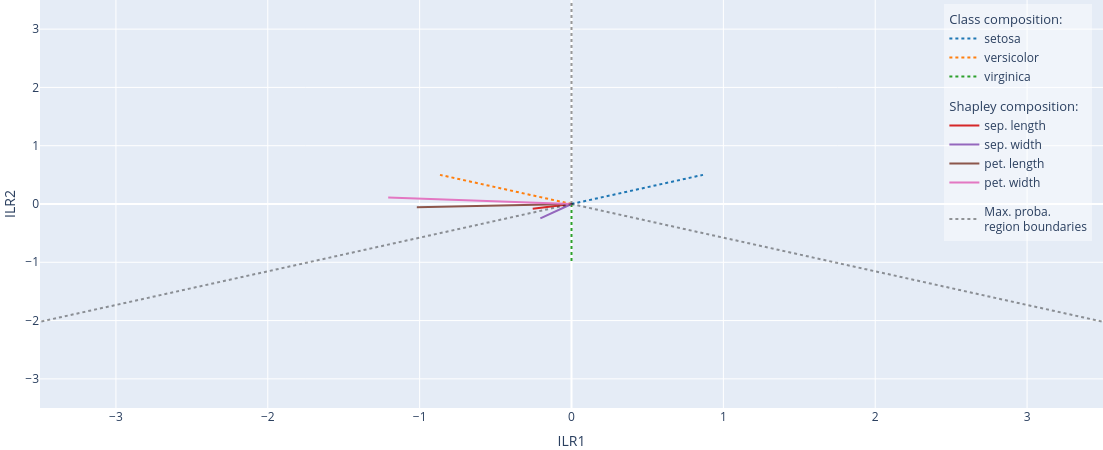

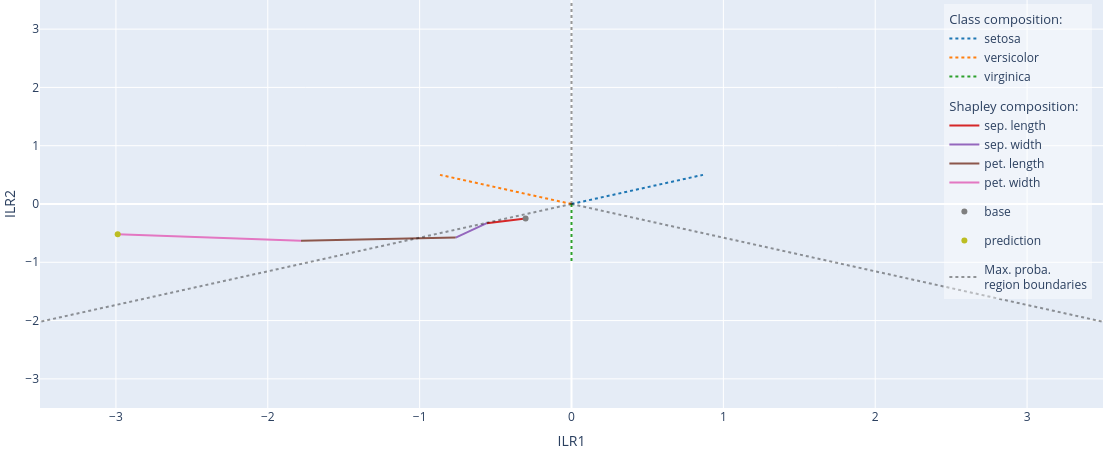

In [9]:
#PLOT the 2D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2], lim=3.5, figsize=450)
fig.write_image(os.path.join(out_dir, 'ex_eq3_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[1, 2], shapley_sum=True, lim=3.5, figsize=450)
fig.write_image(os.path.join(out_dir, 'ex_eq3_ilrplotsum.pdf'))

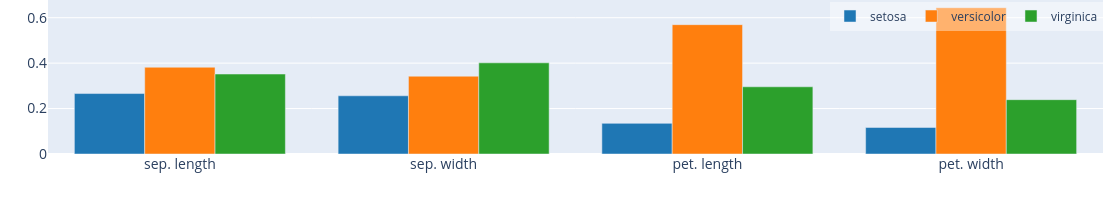

In [10]:
#Plot the Shapley compositions as histograms
fig = explainer.shapley_histogram(figheight=200)
fig.write_image(os.path.join(out_dir, 'ex_eq3_histo.pdf'))

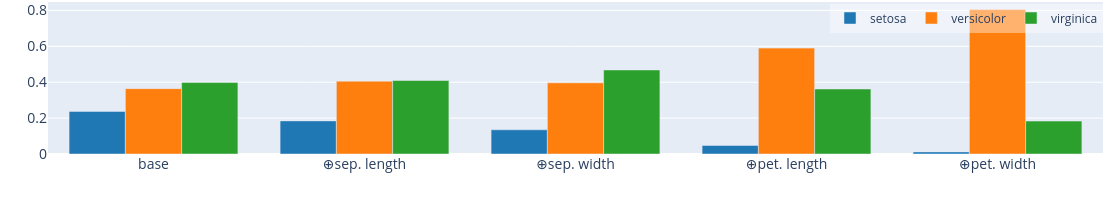

In [11]:
#Plot the perturbation of the base distribution to the prediction with histograms
fig = explainer.shapley_histogram_from_base_to_pred(figheight=200)
#fig = explainer.shapley_histogram_from_base_to_pred(figheight=200, sort=True)

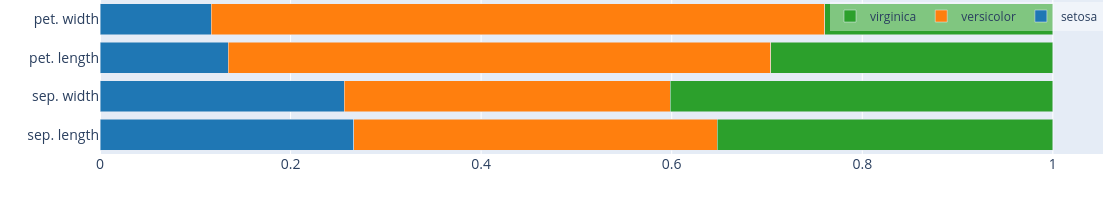

In [12]:
#Plot the Shapley compositions as histograms
fig = explainer.shapley_stacked_hbars(figheight=200)
fig.write_image(os.path.join(out_dir, 'ex_eq3_bars.pdf'))

Number of classes = 3
['Base' '$\\oplus$ sepal length (cm)' '$\\oplus$ sepal width (cm)'
 '$\\oplus$ petal length (cm)' '$\\oplus$ petal width (cm)']
['setosa' 'versicolor' 'virginica']
[[0.23753129 0.1845671  0.13488267 0.0475338  0.0117559 ]
 [0.36420954 0.40613034 0.39663842 0.59018778 0.80475589]
 [0.39825917 0.40930255 0.46847891 0.36227842 0.18348822]]


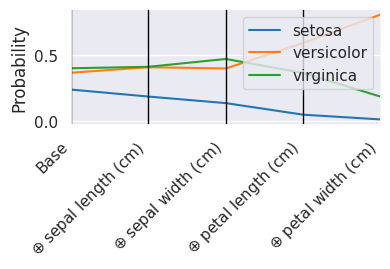

[3 2 1 0]
Number of classes = 3
['Base' '$\\oplus$ petal width ' '$\\oplus$ petal length '
 '$\\oplus$ sepal width ' '$\\oplus$ sepal length ']
['setosa' 'versicolor' 'virginica']
[[0.23753129 0.07759491 0.02260957 0.01652846 0.0117559 ]
 [0.36420954 0.65597053 0.80703513 0.78842442 0.80475589]
 [0.39825917 0.26643456 0.1703553  0.19504712 0.18348822]]


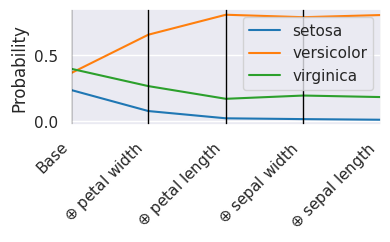

In [13]:
from utils import plot_composite_shapley_feature_contributions

from composition_stats import ilr, sbp_basis
from shapleycomposition import ilr_inv

sbpmatrix=np.array([[1,-1,0],
                    [1,1,-1]])
basis = sbp_basis(sbpmatrix)

space, b = 'Prob', basis
parname, parallel = 'parallel', True

fig = plt.figure(figsize=(4, 1.5))
fig, ax = plot_composite_shapley_feature_contributions(np.array(shapley), base=base, cummulative=True,
                                                       sort_by_norm=False, basis=b,
                                                       parallel=parallel,
                                                       feature_names=[f"$\oplus$ {name}" for name in data.feature_names],
                                                       target_names=data.target_names,
                                                       fig=fig,
                                                       #title=f"Composite Shapley {space} cumsum sorted"
                                                      )
fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_{parname}'), dpi=300, bbox_inches='tight')


fig = plt.figure(figsize=(4, 1.5))
fig, ax = plot_composite_shapley_feature_contributions(np.array(shapley), base=base, cummulative=True,
                                                       sort_by_norm=True, basis=b,
                                                       parallel=parallel,
                                                       feature_names=[f"$\oplus$ {name[:-4]}" for name in data.feature_names],
                                                       target_names=data.target_names,
                                                       fig=fig,
                                                       #title=f"Composite Shapley {space} cumsum sorted"
                                                      )
fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_sorted_{parname}'), dpi=300, bbox_inches='tight')


# Comparison with SHAP

In [14]:
import shap
shap.initjs()

explainer = shap.SamplingExplainer(clf.predict_proba, X_train,
                                   output_names=data.target_names,
                                   feature_perturbation="interventional",
                                   model_output="probability")
shap_values = explainer.shap_values(X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

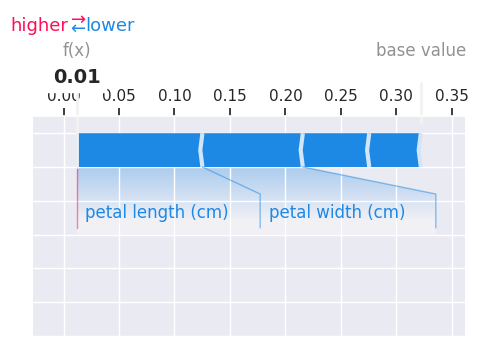

<Figure size 640x480 with 0 Axes>

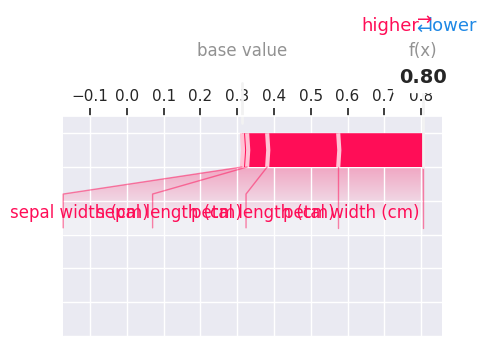

<Figure size 640x480 with 0 Axes>

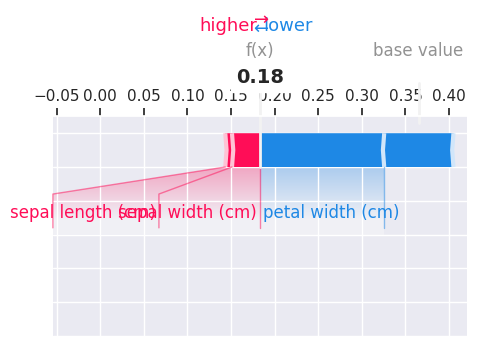

In [15]:
label_id = 0
for label_id in range(N_class):
    plt.clf()
    shap.force_plot(
        base_value=explainer.expected_value[label_id],
        shap_values=shap_values[label_id][K],
        features=data.feature_names,
        matplotlib=True, show=False,
        figsize=(5, 4)
    )
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'ex_eq3_shap_{data.target_names[label_id]}.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

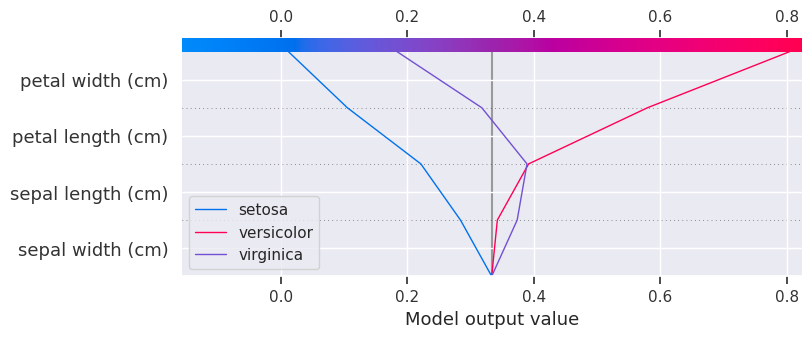

<Figure size 640x480 with 0 Axes>

In [17]:
row_index = K
shap.multioutput_decision_plot(
    explainer.expected_value.tolist(),
    shap_values,
    row_index=K,
    feature_names=data.feature_names,
    legend_labels=data.target_names.tolist(),
    )
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f'ex_eq3_shap_multioutput.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [18]:
shap.force_plot(
    base_value=explainer.expected_value[label_id],
    shap_values=shap_values[label_id][K],
    features=['sep. length','sep. width','pet. length','pet. width']
)

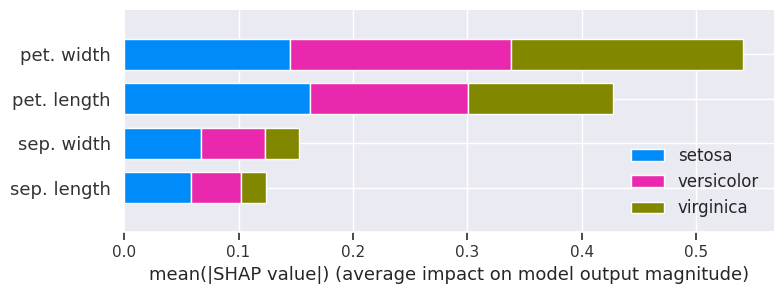

In [19]:
shap.summary_plot(shap_values,X_test,feature_names=['sep. length','sep. width','pet. length','pet. width'],
                  class_names=data.target_names)